# Lesson L3 – Logistic Regression for Tweet Sentiment 📈❤️💔

Welcome to **Lesson L3** of our Colab‑ready DeepLearning.AI NLP remake!

## What you’ll learn
* Convert cleaned tweets into **numeric features**  
* Train a **Logistic Regression** classifier for sentiment  
* **Visualise** tweets in feature‑space and the model’s decision boundary  
* Evaluate accuracy & interpret the learned weights  
* Experiment live with an **interactive Gradio playground**

## Why this matters
Getting from *word counts* → *predictions* is the heart of many NLP systems.  
Logistic Regression is a surprisingly strong baseline and lays the groundwork for neural networks.

## Roadmap
1. **Setup & installs** – one cell, ready for Colab  
2. **Toy example** – six handmade tweets to see LR end‑to‑end  
3. **Real dataset** – 10 k NLTK tweets, build features on the fly  
4. **Visualisation** – scatter & decision boundary  
5. **Evaluation** – accuracy + confusion matrix  
6. **Gradio playground** – paste any text and get a sentiment score  

_👉 Let’s dive in!_


In [14]:
import pandas as pd

In [2]:
# 🍀 Colab setup – run this first!
# Installs pinned to avoid version conflicts with Colab pre‑installs
!pip -q install --upgrade \
        "nltk" \
        "wordcloud" \
        "numpy>=1.26,<2.1" \
        "scikit-learn<1.7" \
        "gradio>=4.27.0" \
        "websockets>=13,<15" --progress-bar off

import nltk, ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
    ssl._create_default_https_context = _create_unverified_https_context
except AttributeError:
    pass

for resource in ['stopwords', 'punkt', 'twitter_samples']:
    nltk.download(resource, quiet=True)

print("✅ Environment & NLTK corpora ready!")


✅ Environment & NLTK corpora ready!


## Let's build a classifier. First Toy, then real!

For the rest of the Colab, we are going to build a bag-of-words–style logistic regression classifier. Our goal is to figure out how much individual words contribute to determining whether a tweet expresses a positive or negative sentiment. To keep things simple and interpretable, we won’t model word order or complex phrasing. Instead, we'll rely on whether certain positive or negative words appear in each tweet, and how often. In the end, each tweet will be reduced to a simple feature vector: just a count of how many positive and how many negative words it contains. Logistic regression will then learn to use those counts to predict sentiment.

## 1️⃣ Toy example – six mini‑tweets
We will take the 6 Tweets, clean them (as in previous lessions) and then use mini sentiment lexicon with the to_features function, to define the sentences as negative or positive by seeing if the key words appear in the sentence. It returns a 2-dimensional feature vector for any given input tokens, where:

pos_cnt: the number of words in the token list that are found in the positive lexicon (pos_lex)

neg_cnt: the number of words in the token list that are found in the negative lexicon (neg_lex)

So each sentence becomes: [positive word count, negative word count]. A given sentence may have several positive and/or negative words.

Key takeaway: in the end we will have a system that looks at how many positive vs negative words are in a tweet, in order to know if the next tweet should be classified as positive or negative.

A bit deeper math intuition:
Only the difference matters — it doesn't care whether the values are [2, 1] or [1, 0], since both give d = 1.

If your model learns weights where the difference dominates, then [2, 1] and [1, 0] are treated the same.

You could think of it as us arriving at a single coeficient value for the difference between postivie or negative, where the coeficient applies to Sigmoid (non-linear function with output 1 or 0).
And by the way, we could develop arbitrarily complex deep neural network (DNN) to solve the same task… but it would be massive overkill.

Now on to the exercise

| Original Tweet                     | Cleaned Tokens              | Features \[pos\_cnt, neg\_cnt] |
| ---------------------------------- | --------------------------- | ------------------------------ |
| "I love this!"                     | \['love']                   | \[1, 0]                        |
| "This is great and makes me happy" | \['great', 'make', 'happi'] | \[2, 0]                        |
| "So happy, great vibes"            | \['happi', 'great', 'vibe'] | \[2, 0]                        |
| "I hate this, really bad"          | \['hate', 'realli', 'bad']  | \[0, 2]                        |
| "This is sad and bad"              | \['sad', 'bad']             | \[0, 2]                        |
| "I hate it so much"                | \['hate', 'much']           | \[0, 1]                        |


In [12]:
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re, numpy as np, matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def simple_process(sentence):
    sentence = sentence.lower()
    sentence = re.sub(r'[^a-z\s]', '', sentence)
    return [stemmer.stem(w) for w in sentence.split() if w not in stop_words]

# Mini sentiment lexicon
pos_lex = {'love','great','happy'}
neg_lex = {'hate','bad','sad'}

def to_features(tokens):
    pos_cnt = sum(w in pos_lex for w in tokens)
    neg_cnt = sum(w in neg_lex for w in tokens)
    return [pos_cnt, neg_cnt]
#The 6 sentences are pre-defined as postive or negative (see np.array which has 1,1,1,0,0,0)
toy_tweets = [
    "I love this!",
    "This is great and makes me happy",
    "So happy, great vibes",
    "I hate this, really bad",
    "This is sad and bad",
    "I hate it so much"
]


For each sentence, the remaining cleaned tokens are evaluated for whether they are positive or negative. This could be visualized in a table like this:

| Original Tweet                     | Cleaned Tokens              | Features \[pos\_cnt, neg\_cnt] |
| ---------------------------------- | --------------------------- | ------------------------------ |
| "I love this!"                     | \['love']                   | \[1, 0]                        |
| "This is great and makes me happy" | \['great', 'make', 'happi'] | \[2, 0]                        |
| "So happy, great vibes"            | \['happi', 'great', 'vibe'] | \[2, 0]                        |
| "I hate this, really bad"          | \['hate', 'realli', 'bad']  | \[0, 2]                        |
| "This is sad and bad"              | \['sad', 'bad']             | \[0, 2]                        |
| "I hate it so much"                | \['hate', 'much']           | \[0, 1]                        |


Let's recreate that table here

In [16]:
# Create DataFrame
data = {
    "Original Tweet": [],
    "Cleaned Tokens": [],
    "Features [pos_cnt, neg_cnt]": []
}

for tweet in toy_tweets:
    tokens = simple_process(tweet)
    features = to_features(tokens)
    data["Original Tweet"].append(tweet)
    data["Cleaned Tokens"].append(tokens)
    data["Features [pos_cnt, neg_cnt]"].append(features)

df = pd.DataFrame(data)

print(df.to_markdown(index=False))


| Original Tweet                   | Cleaned Tokens             | Features [pos_cnt, neg_cnt]   |
|:---------------------------------|:---------------------------|:------------------------------|
| I love this!                     | ['love']                   | [1, 0]                        |
| This is great and makes me happy | ['great', 'make', 'happi'] | [1, 0]                        |
| So happy, great vibes            | ['happi', 'great', 'vibe'] | [1, 0]                        |
| I hate this, really bad          | ['hate', 'realli', 'bad']  | [0, 2]                        |
| This is sad and bad              | ['sad', 'bad']             | [0, 2]                        |
| I hate it so much                | ['hate', 'much']           | [0, 1]                        |


So now we take that intermediate table we have built, and will train a logistic regression that is able to link the features (number of postive words, number of negative words) to whether the sentence is positive or negative (which is predetermined).

How is this done? Well behind the scenes a function is used scikit-learn that uses an optimization algorithm to find the best parameters (weights and bias) that minimize a loss function — typically the log loss (a.k.a. binary cross-entropy).

That optimization is usually done via (stochastic) gradient descent, but we won't focus on the nuts and bolts of gradient descent here, but by default the clf_toy = LogisticRegression() function below uses 100 iterations.



Toy feature matrix:
 [[1 0]
 [1 0]
 [1 0]
 [0 2]
 [0 2]
 [0 1]]
Toy accuracy: 1.0


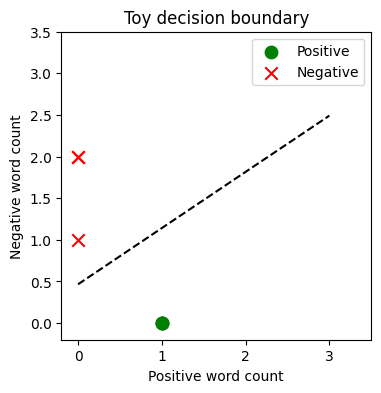

In [4]:
# Define sentiment labels: 1 = positive, 0 = negative
y_toy = np.array([1, 1, 1, 0, 0, 0])

# Convert each tweet into a feature vector: [#positive_words, #negative_words]
X_toy = np.array([to_features(simple_process(t)) for t in toy_tweets])

# Display the resulting feature matrix
print("Toy feature matrix:\n", X_toy)

# Initialize and train a logistic regression classifier on the toy data
clf_toy = LogisticRegression()
clf_toy.fit(X_toy, y_toy)

# Print training accuracy (since this is a toy set, it should be 100%)
print("Toy accuracy:", clf_toy.score(X_toy, y_toy))

# ---------- Visualization ----------

# Create a new 4x4 inch plot
plt.figure(figsize=(4,4))

# Plot the data points with different markers for positive and negative labels
for label, marker, color in [(1, 'o', 'green'), (0, 'x', 'red')]:
    mask = y_toy == label
    plt.scatter(
        X_toy[mask, 0], X_toy[mask, 1],
        marker=marker, color=color,
        label='Positive' if label else 'Negative', s=80
    )

# Extract the learned weights and intercept from the trained model
coef = clf_toy.coef_[0]       # [w1, w2]
intercept = clf_toy.intercept_[0]  # bias term

# Generate x-values to plot the decision boundary line
xs = np.linspace(0, 3, 100)

# Compute corresponding y-values for the decision boundary: w1*x + w2*y + b = 0
ys = -(coef[0]*xs + intercept) / coef[1]

# Plot the decision boundary as a dashed black line
plt.plot(xs, ys, '--k')

# Label the axes
plt.xlabel('Positive word count')
plt.ylabel('Negative word count')

# Set visible limits for clarity
plt.xlim(-0.2, 3.5)
plt.ylim(-0.2, 3.5)

# Add a legend and title
plt.legend()
plt.title("Toy decision boundary")

# Show the final plot
plt.show()


And there you have it, using the built in Gradient Descent function we have arrived at a line that splits positive vs negative tweets based on the number of positive vs negative words. And in the toy example it's always correct for the toy example.

**What to notice**

* Tweets with more *positive cues* sit left of the boundary.  
* LR learns weights to separate the two classes with a straight line.  
* Coefficients magnitude ≈ feature importance.
* The slope and position of that line are determined by the learned weights (coef_) and bias (intercept_).

## Now let's replicate the toy exercise on real Twitter Data

 2️⃣ First let's rebuild the helper functions – inline (no utils.py like in the DeepLearning course. We'll build the code in the Colab environment)

In [5]:
import re, numpy as np
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def process_tweet(tweet: str):
    tweet = tweet.lower()
    tweet = re.sub(r'https?://\S+', '', tweet)
    tweet = re.sub(r'[^a-z\s]', '', tweet)
    return [stemmer.stem(w) for w in tweet.split() if w not in stop_words]

def build_freqs(tweets, ys):
    freqs = {}
    for y, tweet in zip(ys, tweets):
        for word in process_tweet(tweet):
            pair = (word, y)
            freqs[pair] = freqs.get(pair, 0) + 1
    return freqs

def tweet_to_xy(tweet, pos_vocab, neg_vocab):
    tokens = process_tweet(tweet)
    pos_cnt = sum(tok in pos_vocab for tok in tokens)
    neg_cnt = sum(tok in neg_vocab for tok in tokens)
    return np.array([pos_cnt, neg_cnt])


## 3️⃣ Full tweet corpus – build features & train

We will now run the cleaned Tweets through a counter to get the frequency that words appear in both positive and negative Tweets. This will be expressed in a tuplet per word:

For example, for love: freqs[('love', 1)] = 36    # "love" appears 36 times in positive tweets
freqs[('hate', 0)] = 42    # "hate" appears 42 times in negative tweets.

And we filters out rare words (appearing ≤5 times)
Builds two sets:
pos_vocab: words that appear more than 5 times in positive tweets
neg_vocab: words that appear more than 5 times in negative tweets

These vocabularies are your data-driven sentiment lexicons.

In [6]:
from nltk.corpus import twitter_samples
import numpy as np

pos_tweets = twitter_samples.strings('positive_tweets.json')
neg_tweets = twitter_samples.strings('negative_tweets.json')
tweets = pos_tweets + neg_tweets
ys = np.append(np.ones(len(pos_tweets)), np.zeros(len(neg_tweets)))

freqs = build_freqs(tweets, ys)

# Vocab threshold
pos_vocab = {w for (w,y) in freqs if y==1 and freqs[(w,1)] > 5}
neg_vocab = {w for (w,y) in freqs if y==0 and freqs[(w,0)] > 5}

print(f"Positive vocab: {len(pos_vocab)} words | Negative vocab: {len(neg_vocab)} words")

X = np.array([tweet_to_xy(t, pos_vocab, neg_vocab) for t in tweets])
print("Feature matrix shape:", X.shape)


Positive vocab: 780 words | Negative vocab: 796 words
Feature matrix shape: (10000, 2)


Let's print the top 5 positive, negative, and dual-purpose (pos and neg) words.

In [7]:
# Separate word counts
from collections import defaultdict

# Step 1: Build separate dicts for pos and neg counts
pos_counts = defaultdict(int)
neg_counts = defaultdict(int)

for (word, label), count in freqs.items():
    if label == 1:
        pos_counts[word] += count
    else:
        neg_counts[word] += count

# Step 2: Get top 5 positive words
top_pos = sorted(pos_counts.items(), key=lambda x: x[1], reverse=True)[:5]

# Step 3: Get top 5 negative words
top_neg = sorted(neg_counts.items(), key=lambda x: x[1], reverse=True)[:5]

# Step 4: Get top 5 shared words (appear in both pos and neg, ranked by total freq)
shared_words = set(pos_counts) & set(neg_counts)
shared_freqs = [(w, pos_counts[w] + neg_counts[w]) for w in shared_words]
top_shared = sorted(shared_freqs, key=lambda x: x[1], reverse=True)[:5]

# Step 5: Print everything
print("🔵 Top 5 Positive Words:")
for w, c in top_pos:
    print(f"{w:<15} {c}")

print("\n🔴 Top 5 Negative Words:")
for w, c in top_neg:
    print(f"{w:<15} {c}")

print("\n🟣 Top 5 Shared Words (in both pos and neg):")
for w, c in top_shared:
    print(f"{w:<15} {c} (pos: {pos_counts[w]}, neg: {neg_counts[w]})")


🔵 Top 5 Positive Words:
thank           642
follow          447
love            399
day             243
u               241

🔴 Top 5 Negative Words:
im              475
miss            300
pleas           273
follow          263
want            246

🟣 Top 5 Shared Words (in both pos and neg):
thank           749 (pos: 642, neg: 107)
im              716 (pos: 241, neg: 475)
follow          710 (pos: 447, neg: 263)
love            551 (pos: 399, neg: 152)
like            452 (pos: 231, neg: 221)


### Train / test split & model performance

Now we will train logistic regression to classify based on the feature representation of tweets using the vocabulary-based features you built earlier.
In principle, the logistic regression used here is exactly the same as in your toy example. The core algorithm is identical. What changes is the scale and the input representation.



Difference between the toy example and this real example

| Aspect                | Toy Example                    | Twitter Dataset Example                                  |
| --------------------- | ------------------------------ | -------------------------------------------------------- |
| **Features**          | 2D → `[pos_count, neg_count]`  | Potentially hundreds or thousands of word-based features |
| **Data size**         | 6 sentences                    | 10,000 tweets                                            |
| **Vocabulary source** | Manually defined small lexicon | Auto-generated from word frequencies                     |
| **Separability**      | Fully separable in 2D          | Likely not linearly separable in high-dimensional space  |
| **Visualization**     | Easy to plot (2D space)        | Difficult (high-dimensional space)                       |

So behind the scenes, the real model is doing the same kind of math, but in much higher dimensions using vectorized linear algebra.

Train accuracy: 0.662125
Test  accuracy: 0.6615


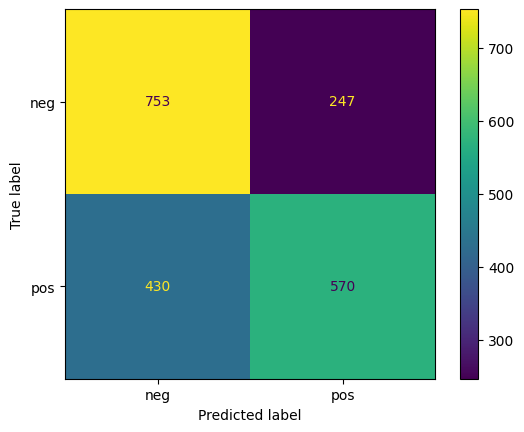

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

X_train, X_test, y_train, y_test = train_test_split(X, ys, test_size=0.2, random_state=42, stratify=ys)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

print("Train accuracy:", accuracy_score(y_train, model.predict(X_train)))
print("Test  accuracy:", accuracy_score(y_test,  model.predict(X_test)))

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, display_labels=['neg','pos'])


### Visualising tweet distribution & decision boundary

The above image shows: This is a confusion matrix plot that shows how your logistic regression model performed on the test set for tweet sentiment classification.

|                    | **Predicted: Negative**          | **Predicted: Positive**          |
| ------------------ | -------------------------------- | -------------------------------- |
| **True: Negative** | **753** = ✅ True Negatives (TN)  | **247** = ❌ False Positives (FP) |
| **True: Positive** | **430** = ❌ False Negatives (FN) | **570** = ✅ True Positives (TP)  |




The visualization produced below shows:

Points below the line have more positive words than negative

Points above the line have more negative words than positive

This is a simple heuristic decision boundary — not from the model, but rather a visual separator.

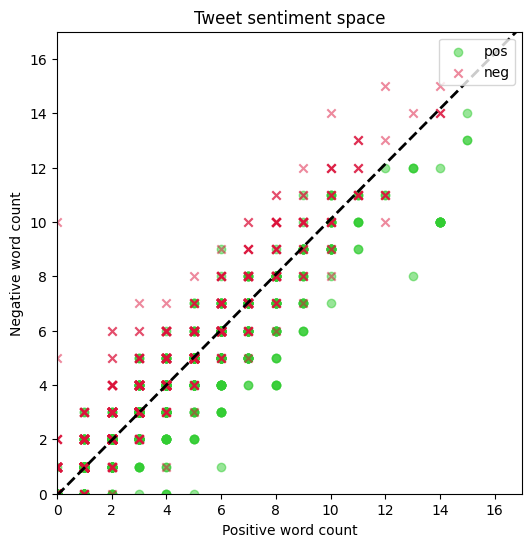

In [9]:
import matplotlib.pyplot as plt

np.random.seed(0)
sample_idx = np.random.choice(len(X), 2000, replace=False)
X_s = X[sample_idx]; y_s = ys[sample_idx]

plt.figure(figsize=(6,6))
for label, marker, col in [(1,'o','limegreen'), (0,'x','crimson')]:
    mask = y_s==label
    plt.scatter(X_s[mask,0], X_s[mask,1], marker=marker, color=col, label='pos' if label else 'neg', alpha=0.5)

coef = model.coef_[0]; intercept=model.intercept_[0]
xs = np.linspace(0, X[:,0].max()+2, 100)
ys_line = -(coef[0]*xs + intercept)/coef[1]
plt.plot(xs, ys_line, '--k', linewidth=2)

plt.xlabel('Positive word count'); plt.ylabel('Negative word count')
plt.title('Tweet sentiment space')
plt.legend(loc='upper right')
plt.xlim(0, X[:,0].max()+1); plt.ylim(0, X[:,1].max()+1)
plt.show()


**Interpretation tips**

* Many tweets contain *no* positive words (x=0) or negative words (y=0); that’s why points hug the axes.  
* Adding richer features (bigrams, TF‑IDF) can separate overlapping clusters.

## 4️⃣ Interactive Gradio sentiment tester

Takes the model WE JUST TRAINED and let's you do a sentiment analysis of any sentence.

In [10]:
import gradio as gr
from collections import Counter

def predict_sentiment(text):
    feats = tweet_to_xy(text, pos_vocab, neg_vocab)
    prob_pos = float(model.predict_proba([feats])[0][1])
    label = "Positive 😊" if prob_pos >= 0.5 else "Negative 😞"
    return {
        "Positive-count": int(feats[0]),
        "Negative-count": int(feats[1]),
        "Prob‑positive": round(prob_pos, 3),
        "Prediction": label
    }

with gr.Blocks() as demo:
    gr.Markdown("### 🎛️ Sentiment tester (Logistic Regression)")
    txt = gr.Textbox(label="Enter tweet text", lines=3)
    out = gr.JSON(label="Model output")
    txt.submit(predict_sentiment, txt, out)
    gr.Button("Run").click(predict_sentiment, txt, out)

# Uncomment the next line when running in Colab
demo.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://045f37645f76df596a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


---

🎉 **You trained, visualised, and deployed a sentiment classifier!**  
Try tweaking the vocabulary threshold, adding TF‑IDF, or swapping in a different model to see how performance changes.